Notebook on learning R, \gamma and p simultaneously using Environment Design

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.make_environment import transition_matrix, Environment, insert_walls_into_T
from src.utils.environment_design import environment_search
from src.utils.visualization import plot_posterior_distribution, plot_environment, plot_trajectories, make_traceplot, plot_log_likelihood
from src.utils.constants import ParamTuple, beta_agent, KnownParameter
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories
from src.experimental.inference.sampling import exp_bayesian_parameter_learning

np.set_printoptions(linewidth=160, precision=2)

Create Environment

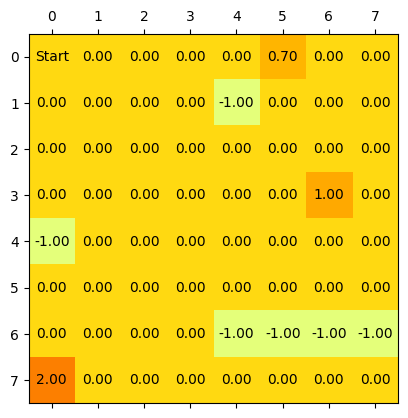

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 8,8
n_states, n_actions = N * M, 4

# TODO describe world
R_true = np.zeros((N, M))
R_true[0, M-3] = 0.7
R_true[3, M-2] = 1
R_true[N-1, 0] = 2
# R_true[N-1, M-1] = 5
# R_true[1, 2] = -1
# R_true[1, 3] = -1
R_true[4, 0] = -1
R_true[1, M-4] = -1
R_true[N-2, M-4] = -1
R_true[N-2, M-3] = -1
R_true[N-2, M-2] = -1
R_true[N-2, M-1] = -1
# R_true = R_true.flatten()

# goal_states = np.where(R_true != 0)[0]

plot_environment(
    R_true.reshape(N, M),
    [])

## Prior sampling


#### Start by finding an environment to generate initial trajectories from


#### Create the unknown true agent and trajectories in the chosen environment


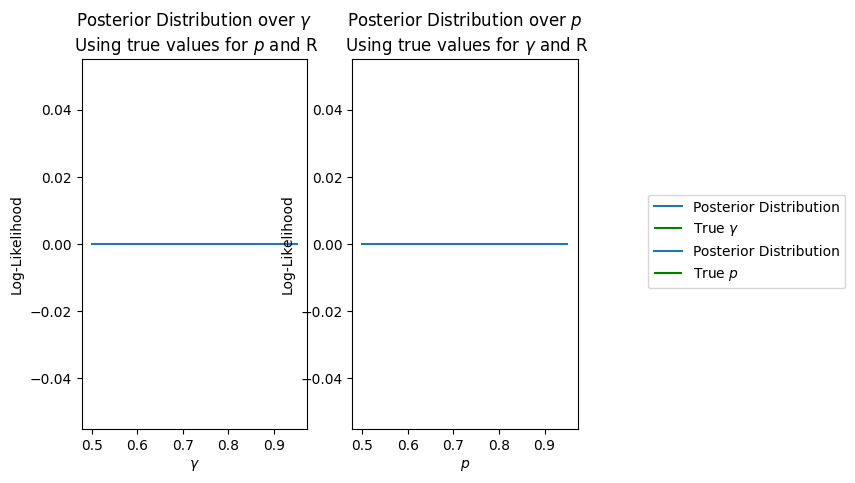

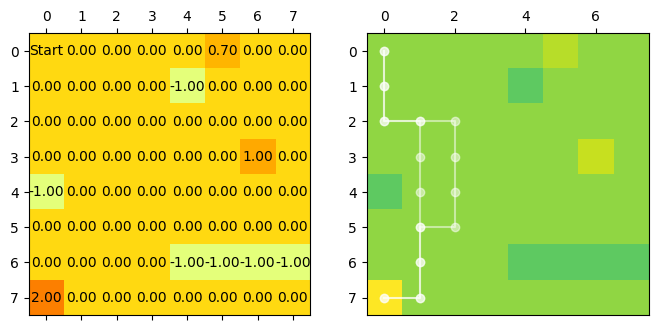

In [4]:
# Start by making the agent we want to learn the policy of
agent_p = 0.95
agent_gamma = 0.9
agent_R = R_true
p_true=0.999

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)


plot_log_likelihood(param_values=true_params, expert_trajectories=[], goal_states=goal_states)


# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories = [(env_agent, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

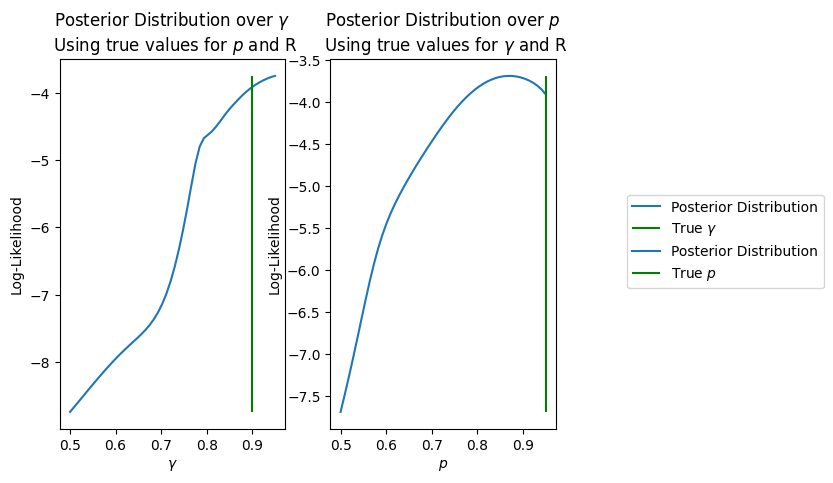

In [5]:
plot_log_likelihood(param_values=true_params, expert_trajectories=expert_trajectories, goal_states=goal_states)

#### Sample from the posterior under these trajectories


#### Start round two, maximize regret with the new posterior


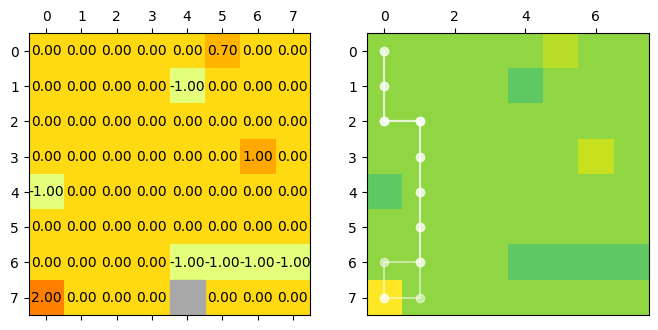

In [6]:
# Generate 2 trajectories in the second round environment
wall_states = [(N-1)*M+4]
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
T_true_iteration_2 = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)

T_true_iteration_2 = insert_walls_into_T(T_true, wall_indices=wall_states) #this is new, we need to add the walls in the environment
#when we do the rollout, otherwise expert behavior makes no sense

agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent_2 = Environment(N=N,M=M,T_true=T_true_iteration_2,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories_2 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)
expert_trajectories = [(env_agent_2, trajectories_2)]
# expert_trajectories.append([env_agent_2, trajectories_2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_2.wall_states,
    start_state=(0),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_2, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

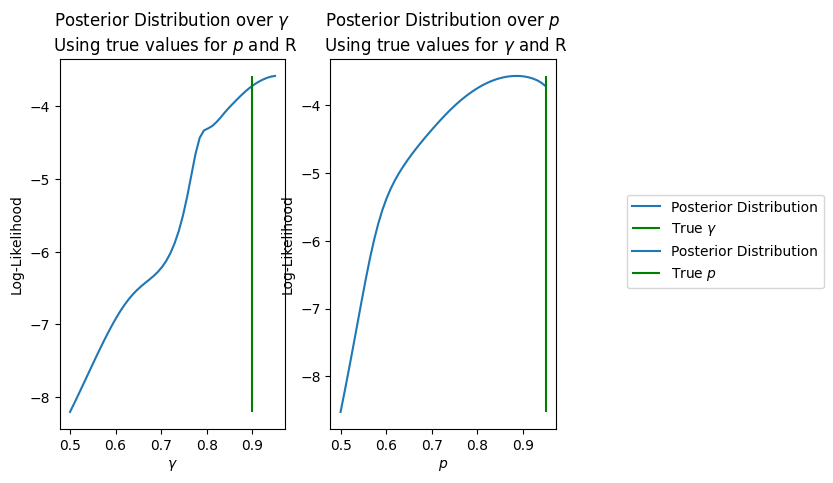

In [7]:
plot_log_likelihood(param_values=true_params, expert_trajectories=expert_trajectories, goal_states=goal_states)

#### Start round three, maximize regret with the new posterior


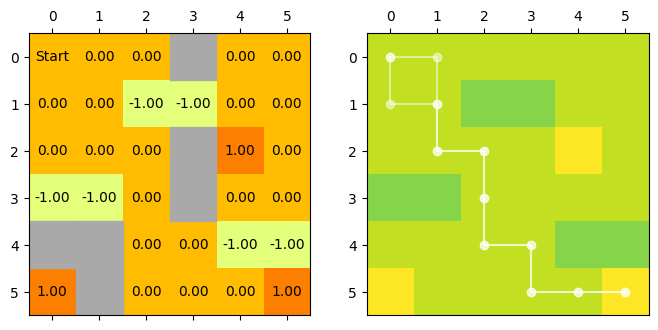

In [11]:
# Generate 2 trajectories in the second round environment
wall_states = [3, 15, 21, 24, 25, 31]
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)

env_agent_3 = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories_3 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories.append([env_agent_3, trajectories_3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_3.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_3, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

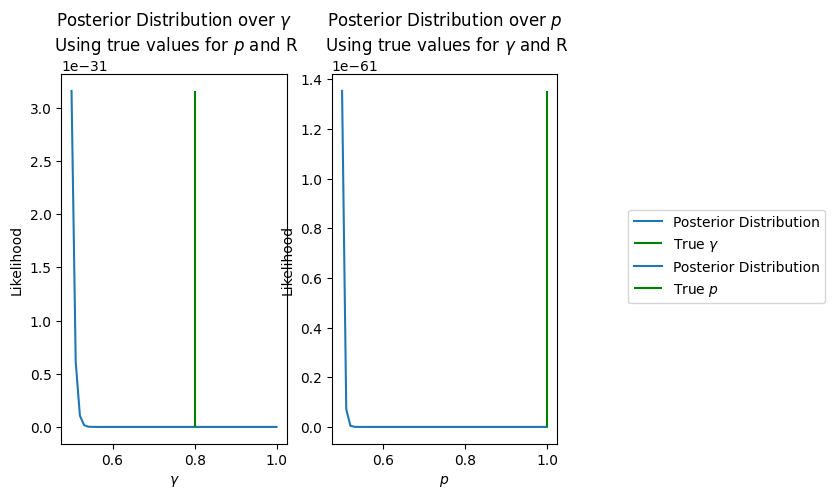

In [12]:
plot_likelihood(param_values=true_params, expert_trajectories=expert_trajectories, goal_states=goal_states)